###  House Prices: Advanced Regression Techniques
#### Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.
#### Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting

#### Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

### 1.Prepare Problem
#### a.Load libraries
#### b.Load dataset
##### for this problem we will be loading training set and test  from two files as given by kaggle 

In [1]:
import os
import warnings
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from datatools.customtransformers import LogTransformer,BoxcoxTransformer,Boxcox1pTransformer
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import (detect_outliers,one_hot_dataframe)
from datatools.dfloader import DataFrameLoader

warnings.filterwarnings('ignore')
% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)


In [2]:
def plot_dataset(dataset,features ,response_column,log=False):
    fig = plt.figure(figsize=(12,8),dpi=200)

   
    for subplot_index ,i in enumerate(range(0,len(features))):
        if(features[i] != response_column ):
            ax = fig.add_subplot(3, 4,  subplot_index + 1)
            if log:
                ax.set(xscale="log",yscale ="log")
            #ax.scatter(X.iloc[:,i],np.log1p(y),marker=".")
            sns.regplot(x=features[i],y= response_column , marker="+", data = dataset,ax=ax)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            plt.tight_layout()
 
    plt.show()

In [3]:
def check_null(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    print("<{0} {1} {0}>".format("="*35,"Dataset null value count"))
    print(null_sum.sort_values(ascending=False))

In [4]:
from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

#### Load settings

In [5]:
load_app_config()
DIRECTORY="kaggle_housing"
TRAIN_FILE ='train.csv'
TEST_FILE = 'test.csv'
RESPONSE = 'SalePrice'
LOG_RESPONSE='LogSalePrice'

Adding D:\DataSource  to system path
Adding D:\MachineLearning  to system path


#### Load Datasets

In [6]:
def get_data_loaders(directory,train_file,test_file):
    input_path = get_datafolder_path()
    train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)
    test_file = os.path.join(input_path, DIRECTORY, TEST_FILE)
    print(train_file)
    print(test_file)
    train_loader = DataFrameLoader(train_file, sep=',',header=0 ,encoding='utf8')
    test_loader  = DataFrameLoader(test_file, sep=',',header=0 ,encoding='utf8')
    return train_loader,test_loader


In [7]:
train_loader ,test_loader = get_data_loaders(DIRECTORY,TRAIN_FILE,TEST_FILE)
X_train =train_loader.dataframe 
X_train[LOG_RESPONSE]=np.log1p(X_train[RESPONSE])
y_train =X_train[LOG_RESPONSE]
X_test = test_loader.dataframe  

D:\DataSource\kaggle_housing\train.csv
D:\DataSource\kaggle_housing\test.csv


In [8]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.2477
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.1090
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.3172
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.8494
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.4292


In [9]:
X_train_continuous = train_loader.continuous_dataframe
X_test_continuous = test_loader.continuous_dataframe
X_train_categorical = train_loader.categorical_dataframe
X_test_categorical = test_loader.categorical_dataframe

In [10]:
X_train_categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [11]:
ordinal_category =['OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold','MSSubClass',]
continuous_features = [ feature for feature in train_loader.continuous_features if feature not in ordinal_category]
categorical_features = train_loader.categorical_features
categorical_features.extend(ordinal_category)
continuous_features  =[feature for feature in continuous_features if feature not in [RESPONSE]]

In [12]:
print("size of categorical features :{}".format(len(categorical_features)))
print("size of continuous  features :{}".format(len(continuous_features)))

X_train_continuous = train_loader.dataframe[continuous_features]
print("Checking null in training dataset")
check_null(X_train_continuous)
X_test_continuous = test_loader.dataframe[continuous_features]
print("Checking null in test dataset")
check_null(X_test_continuous)
X_train[continuous_features].head()

size of categorical features :51
size of continuous  features :29
Checking null in training dataset
<=================================== Dataset null value count ===================================>
LotFrontage    259
MasVnrArea       8
dtype: int64
Checking null in test dataset
<=================================== Dataset null value count ===================================>
LotFrontage     227
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0
1,2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0
2,3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0
3,4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0
4,5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0


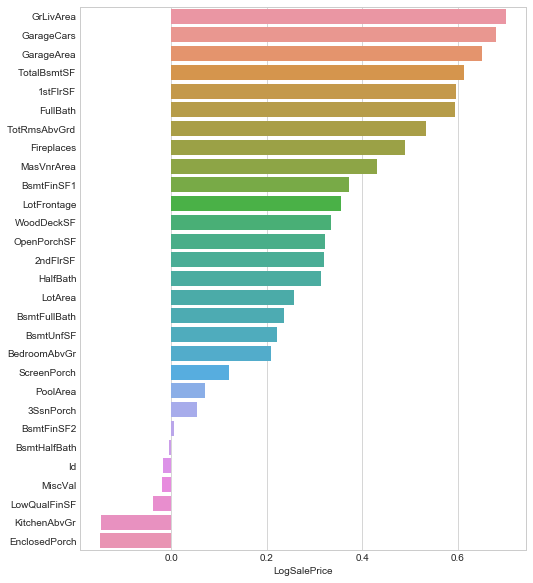

In [13]:
correlation = X_train[continuous_features+[LOG_RESPONSE]].corr()
correlation = correlation.sort_values(LOG_RESPONSE, ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( correlation[LOG_RESPONSE][1:], correlation.index[1:], orient='h')
plt.show()

In [14]:
NA_mapping ={'PoolQC':'No Pool','MiscFeature':'No MiscFeature','Alley':'No Alley',
'Fence':'No Fence','FireplaceQu':'No Fireplace ','GarageYrBlt':-1,
'GarageCond':'No Garage','GarageQual':'No Garage','GarageFinish':'No Garage',
'GarageType':'No Garage','BsmtCond':'No Basement','BsmtQual':'No Basement',
'BsmtExposure':'No Basement','BsmtFinType2':'No Basement','BsmtFinType1':'No Basement' ,
'MasVnrType':'None'
}

for feature in NA_mapping.keys():
    default_value  = NA_mapping.get(feature)
    X_train[feature].fillna(default_value,inplace = True)
    X_test[feature].fillna(default_value,inplace = True)

check_null(X_train[categorical_features])
check_null(X_test[categorical_features])

<=================================== Dataset null value count ===================================>
Electrical    1
dtype: int64
<=================================== Dataset null value count ===================================>
MSZoning       4
Functional     2
Utilities      2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
dtype: int64


In [15]:
X_train[X_train['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
1379,1380,80,RL,73.0,9735,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,No Fireplace,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,5,2008,WD,Normal,167500,12.0287


In [16]:
X_test[X_test['MSZoning'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,No Alley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,No Fireplace,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,No Pool,No Fence,No MiscFeature,0,3,2009,ConLD,Normal
756,2217,20,NaN,80.0,14584,Pave,No Alley,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,No Fireplace,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,2,2008,WD,Abnorml
790,2251,70,NaN,NaN,56600,Pave,No Alley,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,No Fireplace,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2008,WD,Normal
1444,2905,20,NaN,125.0,31250,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,No Fireplace,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,No Pool,No Fence,No MiscFeature,0,5,2006,WD,Normal


In [17]:
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['MSZoning'].value_counts()) 
X_train['Neighborhood'].fillna('RM',inplace = True)
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['MSZoning'].value_counts())
X_train['Neighborhood'].fillna('RM',inplace = True)

### Timber neighborhood has SBrkr as electrical system.
print(X_train[X_train['Neighborhood'] == 'Timber']['Electrical'].value_counts()) 
X_train['Electrical'].fillna('SBrkr',inplace = True)
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['Functional'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['Functional'].value_counts()) 
X_test['Functional'].fillna('Typ',inplace = True)
X_test[X_test['Utilities'].isnull()]

RM         40
C (all)    13
Name: MSZoning, dtype: int64
RM         28
C (all)     9
Name: MSZoning, dtype: int64
SBrkr    36
FuseA     1
Name: Electrical, dtype: int64
Typ     35
Mod      1
Maj2     1
Name: Functional, dtype: int64
Typ     44
Min2     3
Min1     3
Mod      2
Maj2     1
Maj1     1
Name: Functional, dtype: int64


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,No Alley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,No Fireplace,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,No Pool,No Fence,No MiscFeature,0,3,2009,ConLD,Normal
485,1946,20,RL,NaN,31220,Pave,No Alley,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,No Pool,No Fence,Shed,750,5,2008,WD,Normal


In [18]:
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['Utilities'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['Utilities'].value_counts())
print(X_train[X_train['Neighborhood'] == 'Gilbert']['Utilities'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'Gilbert']['Utilities'].value_counts())
X_test[X_test['Utilities'].isnull()]
X_test['Utilities'].fillna('AllPub',inplace = True)

AllPub    37
Name: Utilities, dtype: int64
AllPub    55
Name: Utilities, dtype: int64
AllPub    79
Name: Utilities, dtype: int64
AllPub    85
Name: Utilities, dtype: int64


In [19]:
X_test[X_test['SaleType'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1029,2490,20,RL,85.0,13770,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,10,2007,NaN,Normal


In [20]:
print(X_test[X_test['Neighborhood'] == 'Sawyer']['SaleType'].value_counts())
X_test['SaleType'].fillna('WD',inplace = True)

WD     72
COD     3
Oth     1
Name: SaleType, dtype: int64


In [21]:
X_test[X_test['KitchenQual'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,72.0,10632,Pave,No Alley,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,No Fireplace,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2010,COD,Normal


In [22]:
print(X_test[X_test['Neighborhood'] == 'ClearCr']['KitchenQual'].value_counts())
print(X_train[X_train['Neighborhood'] == 'ClearCr']['KitchenQual'].value_counts())
X_test['KitchenQual'].fillna('TA',inplace = True)

TA    10
Gd     5
Name: KitchenQual, dtype: int64
TA    14
Gd    12
Ex     2
Name: KitchenQual, dtype: int64


In [23]:
X_test[X_test['Exterior1st'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
691,2152,30,RL,85.0,19550,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,No Garage,-1.0,No Garage,0.0,0.0,No Garage,No Garage,Y,0,39,0,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2008,WD,Normal


In [24]:
X_test[X_test['Exterior2nd'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
691,2152,30,RL,85.0,19550,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,No Garage,-1.0,No Garage,0.0,0.0,No Garage,No Garage,Y,0,39,0,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2008,WD,Normal


In [25]:
X_test[ (X_test['Neighborhood'] == 'Edwards') & 
        (X_test['RoofStyle'] == 'Flat') ][ ['Exterior1st','Exterior2nd']]

,Exterior1st,Exterior2nd
691,NaN,NaN
1399,Plywood,Wd Shng


In [26]:
X_train[ (X_train['Neighborhood'] == 'Edwards') & 
                    (X_train['RoofStyle'] == 'Flat')&
                    (X_train['HouseStyle'] == '1Story')][ ['Exterior1st','Exterior2nd']]

,Exterior1st,Exterior2nd
1000,BrkComm,Brk Cmn


In [27]:
X_test[X_test['Exterior1st'].isnull()]
X_test['Exterior1st'].fillna('BrkComm',inplace = True)
X_test['Exterior2nd'].fillna('Brk Cmn',inplace = True)

In [28]:
X_test_categorical[X_test_categorical['MSZoning'].isnull()]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
455,NaN,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,NaN,GasA,TA,N,FuseA,TA,Min1,NaN,Detchd,Unf,TA,TA,N,NaN,NaN,NaN,ConLD,Normal
756,NaN,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,AsbShng,VinylSd,None,Fa,Po,Slab,NaN,NaN,NaN,NaN,NaN,Wall,Po,N,FuseA,Fa,NaN,NaN,Attchd,Unf,Fa,Po,N,NaN,NaN,NaN,WD,Abnorml
790,NaN,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,Hip,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Maj1,NaN,Detchd,Unf,TA,Fa,N,NaN,NaN,NaN,WD,Normal
1444,NaN,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,Gable,CompShg,CBlock,VinylSd,None,TA,Fa,CBlock,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,TA,Mod,NaN,Attchd,Unf,Fa,TA,N,NaN,NaN,NaN,WD,Normal


In [29]:
X_test.loc[455,'MSZoning'] = 'RM'
X_test.loc[756,'MSZoning'] = 'C (all)'
X_test.loc[790,'MSZoning'] = 'RM'
X_test.loc[1444,'MSZoning'] = 'RL'

In [30]:
check_null(X_train)
check_null(X_test)

<=================================== Dataset null value count ===================================>
LotFrontage    259
MasVnrArea       8
dtype: int64
<=================================== Dataset null value count ===================================>
LotFrontage     227
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


In [31]:
X_train.drop(X_train[X_train.GrLivArea >= 4000].index, inplace=True)

In [32]:
full_dataset =pd.concat(objs=[X_train, X_test], axis=0,sort =True).reset_index(drop=True)  

In [33]:
full_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LogSalePrice,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,No Alley,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,No Fence,No Fireplace,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,1,Gd,Lvl,Gtl,12.2477,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,No MiscFeature,0,2,CollgCr,61,5,7,Y,0,No Pool,CompShg,Gable,Normal,208500.0,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,No Alley,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,No Fence,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,2,1,TA,Lvl,Gtl,12.1090,9600,FR2,80.0,Reg,0,20,RL,0.0,None,No MiscFeature,0,5,Veenker,0,8,6,Y,0,No Pool,CompShg,Gable,Normal,181500.0,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,No Alley,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,No Fence,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,3,1,Gd,Lvl,Gtl,12.3172,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,No MiscFeature,0,9,CollgCr,42,5,7,Y,0,No Pool,CompShg,Gable,Normal,223500.0,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,No Alley,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,No Fence,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,4,1,Gd,Lvl,Gtl,11.8494,9550,Corner,60.0,IR1,0,70,RL,0.0,None,No MiscFeature,0,2,Crawfor,35,5,7,Y,0,No Pool,CompShg,Gable,Abnorml,140000.0,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,No Alley,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,No Fence,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,5,1,Gd,Lvl,Gtl,12.4292,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,No MiscFeature,0,12,NoRidge,84,5,8,Y,0,No Pool,CompShg,Gable,Normal,250000.0,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [34]:
full_dataset['BsmtHalfBath'].fillna(0,inplace=True)
full_dataset['BsmtFullBath'].fillna(0,inplace=True)
full_dataset['TotalBsmtSF'].fillna(0,inplace=True)
full_dataset['BsmtUnfSF'].fillna(0,inplace=True)
full_dataset['BsmtFinSF2'].fillna(0,inplace=True)
full_dataset['TotalBsmtSF'].fillna(0,inplace=True)
full_dataset['BsmtFinSF1'].fillna(0,inplace=True)
full_dataset['GarageArea'].fillna(0,inplace=True)
full_dataset['GarageCars'].fillna(0,inplace=True)
full_dataset["MasVnrArea"].fillna(0, inplace=True)

In [35]:
lot_frontage_by_neighborhood = X_train['LotFrontage'].groupby(X_train['Neighborhood'])
for key, group in lot_frontage_by_neighborhood:
    idx = (full_dataset['Neighborhood'] == key) & (full_dataset['LotFrontage'].isnull())
    full_dataset.loc[idx, 'LotFrontage'] = group.median()

In [36]:
check_null(full_dataset)

<=================================== Dataset null value count ===================================>
SalePrice       1459
LogSalePrice    1459
dtype: int64


In [37]:
full_dataset['ExterQual'] = full_dataset['ExterQual'].str.upper().str.strip()
full_dataset['ExterCond'] =full_dataset['ExterCond'].str.upper().str.strip()
full_dataset['KitchenQual'] = full_dataset['KitchenQual'].str.upper().str.strip()
full_dataset['FireplaceQu'] =full_dataset['FireplaceQu'].str.upper().str.strip()
full_dataset['GarageQual'] =full_dataset['GarageQual'].str.upper().str.strip()
full_dataset['GarageCond']=full_dataset['GarageCond'].str.upper().str.strip()

full_dataset['PoolQC'] = full_dataset['PoolQC'].str.upper().str.strip()
full_dataset['BsmtQual'] =full_dataset['BsmtQual'].str.upper().str.strip()
full_dataset['BsmtCond'] =full_dataset['BsmtCond'].str.upper().str.strip()
full_dataset['HeatingQC'] =full_dataset['HeatingQC'].str.upper().str.strip()
full_dataset['BsmtFinType1'] =full_dataset['BsmtFinType1'].str.upper().str.strip()
full_dataset['BsmtFinType2'] =full_dataset['BsmtFinType2'].str.upper().str.strip()
external_quality = full_dataset['ExterQual'].unique().tolist()
print(external_quality)
external_condition = full_dataset['ExterCond'].unique().tolist()
print(external_condition)
kitchen_quality = full_dataset['KitchenQual'].unique().tolist() 
print(kitchen_quality)
fireplace_quality = full_dataset['FireplaceQu'].unique().tolist()
print(fireplace_quality)
garage_quality =  full_dataset['GarageQual'].unique().tolist()
print(garage_quality)
garage_condition=  full_dataset['GarageCond'].unique().tolist()
print(garage_condition)
pool_quality =  full_dataset['PoolQC'].unique().tolist()
print(pool_quality)
basement_quality = full_dataset['BsmtQual'].unique().tolist()
print(basement_quality)
basement_condition = full_dataset['BsmtCond'].unique().tolist()
print(basement_condition)
heating_quality = full_dataset['HeatingQC'].unique().tolist()
print(heating_quality)
basement_finish_type1 = sorted(full_dataset['BsmtFinType1'].unique().tolist())
print(basement_finish_type1)
basement_finish_type2 = sorted(full_dataset['BsmtFinType2'].unique().tolist())
print(basement_finish_type2)

['GD', 'TA', 'EX', 'FA']
['TA', 'GD', 'FA', 'PO', 'EX']
['GD', 'TA', 'EX', 'FA']
['NO FIREPLACE', 'TA', 'GD', 'FA', 'EX', 'PO']
['TA', 'FA', 'GD', 'NO GARAGE', 'EX', 'PO']
['TA', 'FA', 'NO GARAGE', 'GD', 'PO', 'EX']
['NO POOL', 'EX', 'FA', 'GD']
['GD', 'TA', 'EX', 'NO BASEMENT', 'FA']
['TA', 'GD', 'NO BASEMENT', 'FA', 'PO']
['EX', 'GD', 'TA', 'FA', 'PO']
['ALQ', 'BLQ', 'GLQ', 'LWQ', 'NO BASEMENT', 'REC', 'UNF']
['ALQ', 'BLQ', 'GLQ', 'LWQ', 'NO BASEMENT', 'REC', 'UNF']


In [38]:
quality_converter = {'NA':0,'NO FIREPLACE':0,'NO POOL':0,'NO BASEMENT':0,'NO GARAGE':0,'PO':1, 'FA':2,'TA':3 ,'GD':4,'EX' :5}
full_dataset['ExterQual'] = full_dataset['ExterQual'].map(quality_converter)
full_dataset['ExterCond'] =full_dataset['ExterCond'].map(quality_converter)
full_dataset['KitchenQual'] = full_dataset['KitchenQual'].map(quality_converter)
full_dataset['FireplaceQu'] =full_dataset['FireplaceQu'].map(quality_converter)
full_dataset['GarageQual'] =full_dataset['GarageQual'].map(quality_converter)
full_dataset['PoolQC'] = full_dataset['PoolQC'].map(quality_converter)
full_dataset['BsmtQual'] =full_dataset['BsmtQual'].map(quality_converter)
full_dataset['BsmtCond'] =full_dataset['BsmtCond'].map(quality_converter)
full_dataset['HeatingQC'] =full_dataset['HeatingQC'].map(quality_converter)
full_dataset['GarageCond'] =full_dataset['GarageCond'].map(quality_converter)

In [39]:
basement_finish_converter ={ 'NO BASEMENT':0,  'UNF':1, 'LWQ':2,'REC':3,'BLQ':4,'ALQ':5,'GLQ':6}
full_dataset['BsmtFinType1'] =full_dataset['BsmtFinType1'].map(basement_finish_converter)
full_dataset['BsmtFinType2'] =full_dataset['BsmtFinType2'].map(basement_finish_converter)

In [40]:
full_dataset["TotalBath"] = full_dataset["FullBath"] + 0.5*full_dataset["HalfBath"] + full_dataset["BsmtFullBath"] + 0.5*full_dataset["BsmtHalfBath"]
full_dataset["TotalArea"] = full_dataset["GrLivArea"] + full_dataset["TotalBsmtSF"]
#full_dataset['TotalFloorSF'] = full_dataset['1stFlrSF'] + full_dataset['2ndFlrSF']
full_dataset['TotalBsmtFinSF']  = full_dataset['BsmtFinSF1'] + full_dataset['BsmtFinSF2']

In [41]:
garage_finish_map={'No Garage': 0, "Unf": 1, "RFn": 2, "Fin": 3} 
full_dataset['GarageFinish'] = full_dataset['GarageFinish'].map(garage_finish_map)
ordinal_category.append('GarageFinish')
full_dataset['TotalPorchSF'] = (full_dataset['OpenPorchSF'] + full_dataset['EnclosedPorch'] + 
                               full_dataset['3SsnPorch'] + full_dataset['ScreenPorch'])

In [42]:
full_dataset.drop(["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"],axis=1,inplace=True)
full_dataset.drop(['BsmtFinSF1','BsmtFinSF2'],axis=1,inplace=True)
full_dataset.drop(['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)
columns_dropped =['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
                  'BsmtFullBath' ,'BsmtHalfBath' ,'FullBath', 'HalfBath','BsmtFinSF1','BsmtFinSF2']

In [43]:
final_non_count = [feature for feature in continuous_features if feature not in columns_dropped +['Id','SalePrice','LogSalePrice']]
final_non_count = final_non_count + ['TotalBath','TotalArea','TotalBsmtFinSF','TotalPorchSF']

In [44]:
X = full_dataset[sorted(final_non_count)].skew()
skewness = pd.DataFrame( {'Feature':X.index ,
                          'skew':X.values,
                          'max':full_dataset[sorted(final_non_count)].max(),
                          'min':full_dataset[sorted(final_non_count)].min(),
                         'max_min_ratio':full_dataset[sorted(final_non_count)].max()/(full_dataset[sorted(final_non_count)].min()+1)
                          })

remove_skew =skewness[skewness['skew']>1]['Feature'].values.tolist()
skewness[skewness['skew']>1].sort_values(by='skew',ascending=False)

,Feature,skew,max,min,max_min_ratio
MiscVal,MiscVal,21.9434,17000.0,0.0,17000.0000
PoolArea,PoolArea,18.7115,800.0,0.0,800.0000
LotArea,LotArea,13.1305,215245.0,1300.0,165.4458
LowQualFinSF,LowQualFinSF,12.0865,1064.0,0.0,1064.0000
KitchenAbvGr,KitchenAbvGr,4.3011,3.0,0.0,3.0000
MasVnrArea,MasVnrArea,2.6020,1600.0,0.0,1600.0000
TotalPorchSF,TotalPorchSF,2.2446,1207.0,0.0,1207.0000
WoodDeckSF,WoodDeckSF,1.8492,1424.0,0.0,1424.0000
1stFlrSF,1stFlrSF,1.2537,5095.0,334.0,15.2090
LotFrontage,LotFrontage,1.0934,313.0,21.0,14.2273


In [45]:
remove_skew.remove('KitchenAbvGr')

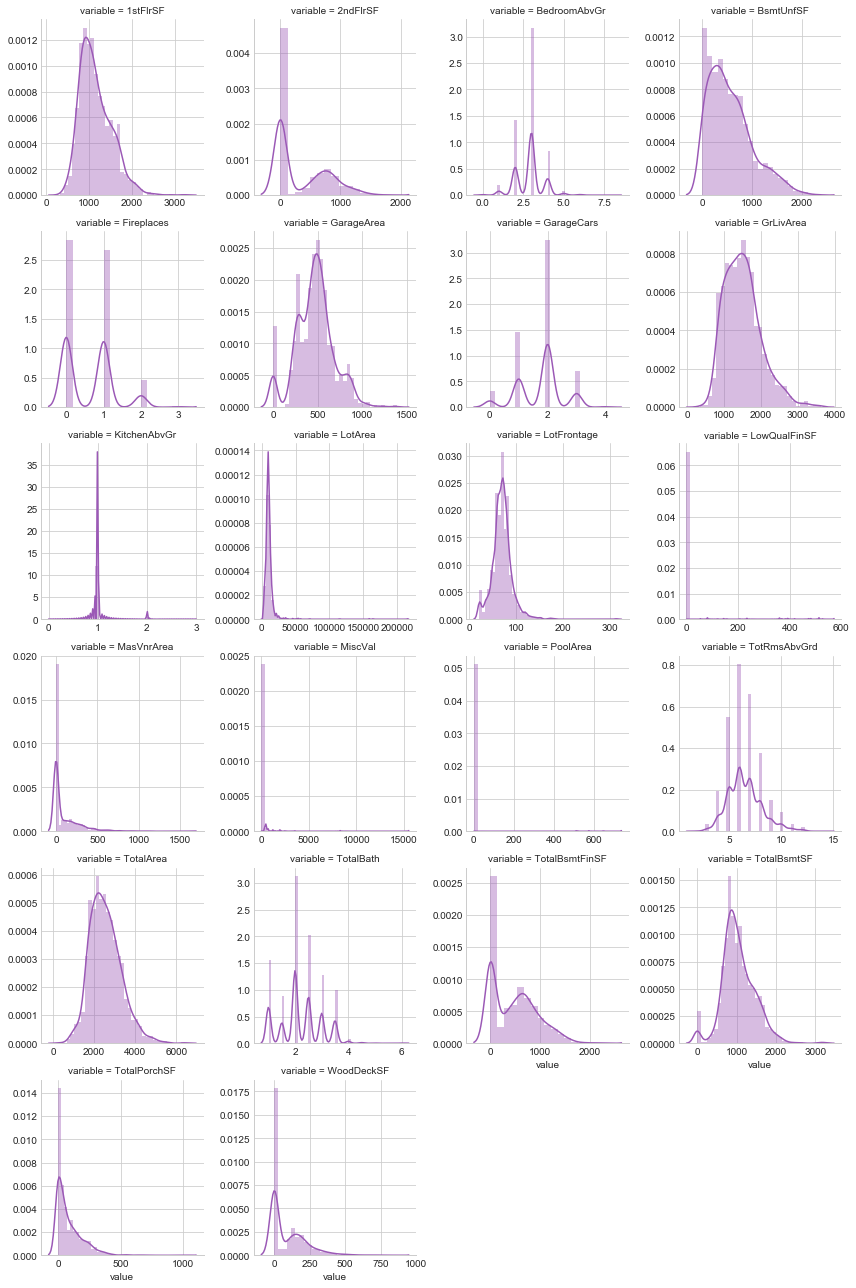

In [46]:
f = pd.melt(full_dataset[full_dataset['SalePrice'].notnull()], value_vars=sorted(final_non_count))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

In [47]:
power_transformed_columns =remove_skew

In [48]:
full_dataset[power_transformed_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
1stFlrSF,2915.0,1156.8213,383.9568,334.0,876.0,1082.0,1383.5,5095.0
LotArea,2915.0,10133.6487,7806.1985,1300.0,7474.0,9450.0,11554.5,215245.0
LotFrontage,2915.0,69.4039,21.1348,21.0,60.0,70.0,80.0,313.0
LowQualFinSF,2915.0,4.7009,46.4283,0.0,0.0,0.0,0.0,1064.0
MasVnrArea,2915.0,100.5993,176.9788,0.0,0.0,0.0,162.5,1600.0
MiscVal,2915.0,50.8957,567.7884,0.0,0.0,0.0,0.0,17000.0
PoolArea,2915.0,1.8998,33.0206,0.0,0.0,0.0,0.0,800.0
TotalPorchSF,2915.0,89.0889,107.7491,0.0,0.0,50.0,136.0,1207.0
WoodDeckSF,2915.0,93.5039,126.4551,0.0,0.0,0.0,168.0,1424.0


In [49]:
bc_transformer = BoxcoxTransformer(power_transformed_columns) 
full_dataset = bc_transformer.fit_transform(full_dataset)

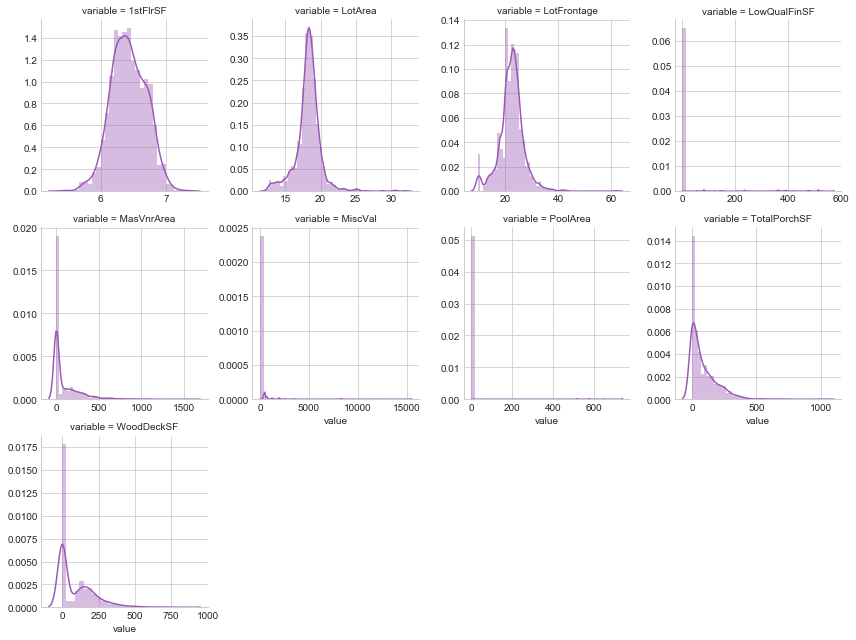

In [50]:
f = pd.melt(full_dataset[full_dataset['SalePrice'].notnull()], value_vars=sorted(power_transformed_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

In [51]:
full_dataset[sorted(power_transformed_columns)].skew()

1stFlrSF       -9.6465e-05
LotArea         1.1112e-01
LotFrontage     1.6855e-01
LowQualFinSF    1.2087e+01
MasVnrArea      2.6020e+00
MiscVal         2.1943e+01
PoolArea        1.8711e+01
TotalPorchSF    2.2446e+00
WoodDeckSF      1.8492e+00
dtype: float64

In [52]:
full_dataset["HighSeason"] = full_dataset["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
full_dataset["NewerDwelling"] = full_dataset["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})
full_dataset["HighSeason"] =full_dataset["HighSeason"].astype(str)
full_dataset["NewerDwelling"] =full_dataset["NewerDwelling"].astype(str)
categorical_features.append('HighSeason')
categorical_features.append('NewerDwelling')

In [53]:
cat_data =  full_dataset[full_dataset['SalePrice'].notnull()] [categorical_features+['SalePrice']]
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x = plt.xticks(rotation=90)

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

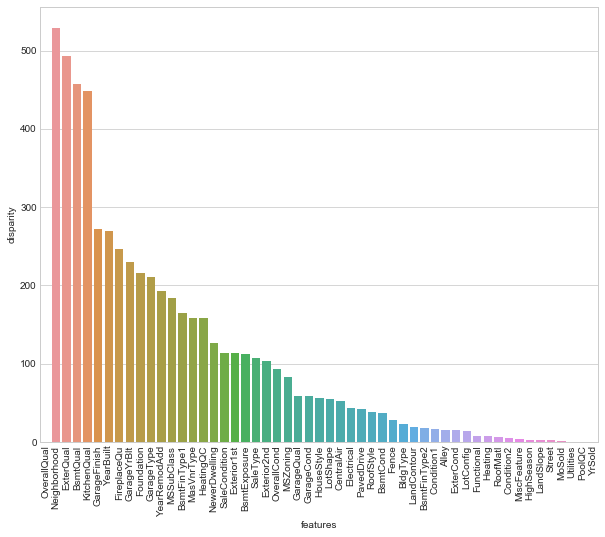

In [54]:
from scipy import stats
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = categorical_features
    pvals = []
    for c in categorical_features:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

 
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 

plt.figure(figsize=(10,8))
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

In [55]:
full_dataset_copy =full_dataset.copy()

In [56]:
MSZoning_map  ={'C (all)':1,'RM':2,'RH':2, 'RL':3,'FV':3}
Neighborhood_map ={"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1,
                   "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2, 
                   "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3, "Somerst" : 3, "Timber" : 3, 
                   "StoneBr" : 4, "NoRidge" : 4, "NridgHt" : 4}
Neighborhood_Good_map ={'Blueste':1,'NPkVill':1,'Veenker':1,'BrDale':1,'MeadowV':1,
'Blmngtn':1,'StoneBr':1,'SWISU':1,'ClearCr':1,'IDOTRR':1,
'Timber':2,'NoRidge':2,'Mitchel':2,'Crawfor':2,'BrkSide':2,
'SawyerW':3,'NWAmes':3,'Sawyer':3,'NridgHt':3,'Gilbert':3,
'Somerst':5,'Edwards':5,'OldTown':5,'CollgCr':5,'NAmes':5}
BsmtExposure_map = { 'No Basement':0 ,'No':1,'Mn':2,'Av':3,'Gd':4}
MSSubClass_map = {30:'0',180:'1',45:'1',190:'1',90:'1',150:'1',160:'1',
                  50:'2',85:'2',40:'2',70:'3',80:'3',20:'3',75:'3',120:'3',60:'4'}
SaleCondition_map ={'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0}
Fence_map ={'No Fence': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4} 
full_dataset['MSZoning_Rank'] =full_dataset['MSZoning'].map(MSZoning_map)
full_dataset['BsmtExposure_Rank'] =full_dataset['BsmtExposure'].map(BsmtExposure_map)
full_dataset['MSSubClass'] =full_dataset['MSSubClass'].map(MSSubClass_map)
full_dataset['Neighborhood_Rank'] =full_dataset['Neighborhood'].map(Neighborhood_map)
full_dataset['SaleCondition_Rank'] =full_dataset['SaleCondition'].map(SaleCondition_map)
full_dataset["Fence_Rank"] = full_dataset["Fence"].map(Fence_map)

full_dataset["Age"] = 2010 - full_dataset["YearBuilt"]
full_dataset["TimeSinceSold"] = 2010 - full_dataset["YrSold"]
full_dataset["SeasonSold"] = full_dataset["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
full_dataset["YearsSinceRemodel"] = full_dataset["YrSold"] - full_dataset["YearRemodAdd"]
#full_dataset['HasBasement'] = full_dataset['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
#full_dataset['HasGarage'] = full_dataset['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
full_dataset['HasPool'] = full_dataset['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
full_dataset['HasPorch'] = full_dataset['TotalPorchSF'].apply(lambda x: 1 if x > 0 else 0)
full_dataset['WasCompleted'] = (full_dataset['SaleCondition']!= 'Partial').astype(np.int64)
full_dataset.loc[full_dataset_copy['Neighborhood'] == 'NridgHt', "Neighborhood_Good"] = 1
full_dataset.loc[full_dataset_copy['Neighborhood']== 'Crawfor', "Neighborhood_Good"] = 1
full_dataset.loc[full_dataset_copy['Neighborhood'] == 'StoneBr', "Neighborhood_Good"] = 1
full_dataset.loc[full_dataset_copy['Neighborhood'] == 'Somerst', "Neighborhood_Good"] = 1
full_dataset.loc[full_dataset_copy['Neighborhood'] == 'NoRidge', "Neighborhood_Good"] = 1
full_dataset["Neighborhood_Good"].fillna(0, inplace=True)

In [57]:
full_dataset["IsRegularLotShape"] = (full_dataset["LotShape"] == "Reg") * 1
#full_dataset["IsLandLevel"] = (full_dataset["LandContour"] == "Lvl") * 1
#full_dataset["IsLandSlopeGentle"] = (full_dataset["LandSlope"] == "Gtl") * 1
#full_dataset["IsElectricalSBrkr"] = (full_dataset["Electrical"] == "SBrkr") * 1
#full_dataset["IsGarageDetached"] = (full_dataset["GarageType"] == "Detchd") * 1
#full_dataset["IsPavedDrive"] = (full_dataset["PavedDrive"] == "Y") * 1
#full_dataset["HasShed"] = (full_dataset["MiscFeature"] == "Shed") * 1
full_dataset["Remodeled"] = (full_dataset["YearRemodAdd"] != full_dataset["YearBuilt"]) * 1
#full_dataset["BldgType_1Fam"] = (full_dataset["BldgType"] == "1Fam") * 1
full_dataset["CentralAir"] = (full_dataset["CentralAir"] == "Y") * 1
#full_dataset["IsSaleType=WD"] = (full_dataset["SaleType"] == "WD") * 1
#full_dataset["RecentRemodel"] = (full_dataset["YearRemodAdd"] == full_dataset["YrSold"]) * 1
full_dataset["VeryNewHouse"] = (full_dataset["YearBuilt"] == full_dataset["YrSold"]) * 1
full_dataset['Dual_Condition'] = (full_dataset['Condition1']!='Normal')&(full_dataset['Condition1']!=full_dataset['Condition2'])*1

In [58]:
#full_dataset["SaleCondition_PriceDown"] = full_dataset_copy['SaleCondition'].replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})
#full_dataset["BoughtOffPlan"] = full_dataset_copy['SaleCondition'].replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

In [59]:
year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20))  for i in range(0, 7))
full_dataset["YearBuilt_bin"] =full_dataset['YearBuilt'].map(year_map)
full_dataset["YearRemodAdd_bin"] = full_dataset['YearRemodAdd'].map(year_map)
#full_dataset["YrSold_bin"] =full_dataset['YrSold'].map(year_map)
full_dataset["YearRemodAdd_bin"] = full_dataset['YearRemodAdd'].map(year_map)
categorical_features.append('YearBuilt_bin')
categorical_features.append('YearRemodAdd_bin')
#categorical_features.append('YrSold_bin')
full_dataset.drop(['YearBuilt','YearRemodAdd'],axis =1,inplace =True)
categorical_features.remove('YearBuilt')
categorical_features.remove('YearRemodAdd') 
categorical_features.remove('YrSold') 

In [60]:
from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer
rbst_scaler = RobustScaleTransformer(final_non_count)
full_dataset =rbst_scaler.fit_transform(full_dataset)

In [61]:
full_dataset[final_non_count].head()

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,PoolArea,MiscVal,TotalBath,TotalArea,TotalBsmtFinSF,TotalPorchSF
0,-0.2529,-0.2553,1.2062,-0.5433,-0.2601,-0.5144,1.2139,0.0,0.4344,0.0,0.0,1.0,-1.0,0.0,0.2695,0.0000,0.0,0.0,1.5,0.1153,0.3111,0.0809
1,0.4873,0.0363,0.0000,-0.3136,0.5399,0.3362,0.0000,0.0,-0.2917,0.0,0.0,0.0,0.0,0.0,-0.0742,1.7738,0.0,0.0,0.5,0.0728,0.6497,-0.3676
2,-0.1003,0.4059,0.9969,-0.0566,-0.1340,-0.3558,1.2310,0.0,0.5575,0.0,0.0,0.0,0.0,0.0,0.5039,0.0000,0.0,0.0,1.5,0.2568,0.0373,-0.0588
3,-0.5127,0.0242,0.0000,0.1251,-0.4571,-0.2600,1.0746,0.0,0.4457,0.0,0.0,0.5,0.0,1.0,0.6367,0.0000,0.0,0.0,0.0,0.0212,-0.2987,1.8897
4,0.6761,0.9738,2.1538,0.0394,0.3094,0.1238,1.4968,0.0,1.2253,1.0,0.0,1.5,0.0,1.0,1.3945,1.1429,0.0,0.0,1.5,0.9009,0.2477,0.2500


In [62]:
test_dataset  =  full_dataset[full_dataset['SalePrice'].isnull()]
train_dataset =  full_dataset[full_dataset['SalePrice'].notnull()]
test_dataset,test_dataset_ignore = one_hot_dataframe(test_dataset, test_dataset.columns.values.tolist(), replace=True)
train_dataset,train_dataset_ignore = one_hot_dataframe(train_dataset, train_dataset.columns.values.tolist(), replace=True)

In [63]:
full_dataset,full_dataset_ignore = one_hot_dataframe(full_dataset, full_dataset.columns.values.tolist(),
                                                     replace=True)

In [64]:
full_columns = full_dataset.columns.values.tolist()
test_columns = test_dataset.columns.values.tolist()
train_columns = train_dataset.columns.values.tolist()
columns_not_matching = set(full_columns) - set(test_columns)
print(columns_not_matching)
traincolumns_not_matching = set(full_columns) - set(train_columns)
print(traincolumns_not_matching)

{'Exterior1st=Stone', 'Exterior1st=ImStucc', 'RoofMatl=Roll', 'Heating=Floor', 'Electrical=Mix', 'Condition2=RRAe', 'MiscFeature=TenC', 'HouseStyle=2.5Fin', 'Utilities=NoSeWa', 'Exterior2nd=Other', 'Condition2=RRNn', 'RoofMatl=Membran', 'RoofMatl=Metal', 'Heating=OthW', 'Condition2=RRAn'}
set()


In [65]:
train_dataset = full_dataset[full_dataset['SalePrice'].notnull()]
train_dataset.head()

,1stFlrSF,2ndFlrSF,Age,Alley=Grvl,Alley=No Alley,Alley=Pave,BedroomAbvGr,BldgType=1Fam,BldgType=2fmCon,BldgType=Duplex,BldgType=Twnhs,BldgType=TwnhsE,BsmtCond,BsmtExposure=Av,BsmtExposure=Gd,BsmtExposure=Mn,BsmtExposure=No,BsmtExposure=No Basement,BsmtExposure_Rank,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtUnfSF,CentralAir,Condition1=Artery,Condition1=Feedr,Condition1=Norm,Condition1=PosA,Condition1=PosN,Condition1=RRAe,Condition1=RRAn,Condition1=RRNe,Condition1=RRNn,Condition2=Artery,Condition2=Feedr,Condition2=Norm,Condition2=PosA,Condition2=PosN,Condition2=RRAe,Condition2=RRAn,Condition2=RRNn,Dual_Condition,Electrical=FuseA,Electrical=FuseF,Electrical=FuseP,Electrical=Mix,Electrical=SBrkr,ExterCond,ExterQual,Exterior1st=AsbShng,Exterior1st=AsphShn,Exterior1st=BrkComm,Exterior1st=BrkFace,Exterior1st=CBlock,Exterior1st=CemntBd,Exterior1st=HdBoard,Exterior1st=ImStucc,Exterior1st=MetalSd,Exterior1st=Plywood,Exterior1st=Stone,Exterior1st=Stucco,Exterior1st=VinylSd,Exterior1st=Wd Sdng,Exterior1st=WdShing,Exterior2nd=AsbShng,Exterior2nd=AsphShn,Exterior2nd=Brk Cmn,Exterior2nd=BrkFace,Exterior2nd=CBlock,Exterior2nd=CmentBd,Exterior2nd=HdBoard,Exterior2nd=ImStucc,Exterior2nd=MetalSd,Exterior2nd=Other,Exterior2nd=Plywood,Exterior2nd=Stone,Exterior2nd=Stucco,Exterior2nd=VinylSd,Exterior2nd=Wd Sdng,Exterior2nd=Wd Shng,Fence=GdPrv,Fence=GdWo,Fence=MnPrv,Fence=MnWw,Fence=No Fence,Fence_Rank,FireplaceQu,Fireplaces,Foundation=BrkTil,Foundation=CBlock,Foundation=PConc,Foundation=Slab,Foundation=Stone,Foundation=Wood,Functional=Maj1,Functional=Maj2,Functional=Min1,Functional=Min2,Functional=Mod,Functional=Sev,...,MiscFeature=Othr,MiscFeature=Shed,MiscFeature=TenC,MiscVal,MoSold,Neighborhood=Blmngtn,Neighborhood=Blueste,Neighborhood=BrDale,Neighborhood=BrkSide,Neighborhood=ClearCr,Neighborhood=CollgCr,Neighborhood=Crawfor,Neighborhood=Edwards,Neighborhood=Gilbert,Neighborhood=IDOTRR,Neighborhood=MeadowV,Neighborhood=Mitchel,Neighborhood=NAmes,Neighborhood=NPkVill,Neighborhood=NWAmes,Neighborhood=NoRidge,Neighborhood=NridgHt,Neighborhood=OldTown,Neighborhood=SWISU,Neighborhood=Sawyer,Neighborhood=SawyerW,Neighborhood=Somerst,Neighborhood=StoneBr,Neighborhood=Timber,Neighborhood=Veenker,Neighborhood_Good,Neighborhood_Rank,NewerDwelling=0,NewerDwelling=1,OverallCond,OverallQual,PavedDrive=N,PavedDrive=P,PavedDrive=Y,PoolArea,PoolQC,Remodeled,RoofMatl=CompShg,RoofMatl=Membran,RoofMatl=Metal,RoofMatl=Roll,RoofMatl=Tar&Grv,RoofMatl=WdShake,RoofMatl=WdShngl,RoofStyle=Flat,RoofStyle=Gable,RoofStyle=Gambrel,RoofStyle=Hip,RoofStyle=Mansard,RoofStyle=Shed,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial,SaleCondition_Rank,SalePrice,SaleType=COD,SaleType=CWD,SaleType=Con,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,SeasonSold,Street=Grvl,Street=Pave,TimeSinceSold,TotRmsAbvGrd,TotalArea,TotalBath,TotalBsmtFinSF,TotalBsmtSF,TotalPorchSF,Utilities=AllPub,Utilities=NoSeWa,VeryNewHouse,WasCompleted,WoodDeckSF,YearBuilt_bin=YearBin1,YearBuilt_bin=YearBin2,YearBuilt_bin=YearBin3,YearBuilt_bin=YearBin4,YearBuilt_bin=YearBin5,YearBuilt_bin=YearBin6,YearBuilt_bin=YearBin7,YearRemodAdd_bin=YearBin4,YearRemodAdd_bin=YearBin5,YearRemodAdd_bin=YearBin6,YearRemodAdd_bin=YearBin7,YearsSinceRemodel,YrSold
0,-0.5144,1.2139,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,1.0,4.0,-0.5433,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,5.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0

In [66]:
test_columns.remove('SaleCondition=Partial')
test_columns.remove('YrSold')
test_columns.remove('NewerDwelling=0')
test_columns.remove('HighSeason=0')
test_columns.remove('Street=Grvl')
test_columns.remove('Condition1=Norm')
test_columns.remove('Exterior2nd=VinylSd')
test_columns.remove('Exterior2nd=MetalSd')
test_columns.remove('SaleType=New')
test_columns.remove('Fence=No Fence')
test_columns.remove('MiscFeature=No MiscFeature')
test_columns.remove('PoolQC')
test_columns.remove('Exterior1st=CemntBd')
test_columns.remove('RoofStyle=Gable')
test_columns.remove('YearRemodAdd_bin=YearBin7')
test_columns.remove('LandSlope=Gtl')
test_columns.remove('MSZoning=RM')
test_columns.remove('HouseStyle=1.5Fin')
test_columns.remove('FireplaceQu')

test_columns.remove('Exterior1st=Wd Sdng')
test_columns.remove('GarageArea')
test_columns.remove('Exterior1st=HdBoard')
### Remork03 top 691
test_columns.remove('PavedDrive=N')
test_columns.remove('Electrical=SBrkr')
test_columns.remove('MasVnrType=BrkFace')
test_columns.remove('HouseStyle=2Story')
test_columns.remove('TotRmsAbvGrd')
test_columns.remove('MSZoning=RL')
### Remork03 top 682
test_columns.remove('TotalArea')
test_columns.remove('SaleCondition_Rank')

#test_columns.remove('GarageYrBlt')
test_columns.remove('YearBuilt_bin=YearBin7')
test_columns.remove('GarageType=No Garage')
#test_columns.remove('GarageCond') 

In [67]:
train_Id  = full_dataset[full_dataset['SalePrice'].notnull()]["Id"]
test_Id = full_dataset[full_dataset['SalePrice'].isnull()]["Id"]
full_dataset.drop(['Id'],axis=1,inplace=True)
test_columns.remove('Id')
train_X = full_dataset[full_dataset['SalePrice'].notnull()][test_columns]
test_X = full_dataset[full_dataset['SalePrice'].isnull()]  [test_columns]
train_y= full_dataset[full_dataset['LogSalePrice'].notnull()]['LogSalePrice']
train_X.drop(['SalePrice','LogSalePrice'],axis=1,inplace=True)
test_X.drop(['SalePrice','LogSalePrice'],axis=1,inplace=True)

In [68]:
check_null(train_X)
check_null(test_X)

<=================================== Dataset null value count ===================================>
Series([], dtype: int64)
<=================================== Dataset null value count ===================================>
Series([], dtype: int64)


In [69]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)

(1456, 226)
(1459, 226)


In [70]:
def best_fit_search(grid,train_X,train_y):
    
    grid.fit(X=train_X,y=train_y)
    print(grid.best_score_)
    print(grid.best_params_)
    best_model =grid.best_estimator_
    best_model.fit(X = X_trainmodel,y = y_trainmodel)
    y_pred_val= best_model.predict(X= X_val)
    print ("RMSLE Value: ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
    train_sizes, train_scores, validation_scores = learning_curve(best_model, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return best_model

RMSLE Value :  0.28700185341955203


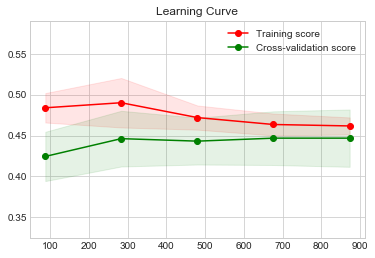

In [71]:
from sklearn.linear_model import ElasticNet
elnet_regr = ElasticNet(random_state=0,fit_intercept=True, normalize = False)
elnet_regr.fit(X = X_trainmodel,y = y_trainmodel)
y_pred_val= elnet_regr.predict(X= X_val)
print ("RMSLE Value : ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
train_sizes, train_scores, validation_scores = learning_curve(elnet_regr, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
plot_learning_curve(train_sizes, train_scores, validation_scores)

In [72]:
param_grid = {'alpha': [0.00006,0.0001,0.0004,0.0006],
              'l1_ratio': [0.005,0.001, .1, .5,.9],
              'max_iter':[10000],
              'fit_intercept':[True],
              'normalize':[ False]
                 }

In [73]:
from sklearn.linear_model import ElasticNetCV
elnet_cv = ElasticNetCV(cv=5, random_state=0,max_iter =10000,alphas= np.logspace(-6, -1, 10),l1_ratio=[0.005,0.001, .1, 1.0,10.0])
print(elnet_cv)
elnet_cv.fit(X_trainmodel, y_trainmodel)
y_pred_val= elnet_cv.predict(X= X_val)
print ("RMSLE Value :",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))


ElasticNetCV(alphas=array([1.00000e-06, 3.59381e-06, 1.29155e-05, 4.64159e-05, 1.66810e-04,
       5.99484e-04, 2.15443e-03, 7.74264e-03, 2.78256e-02, 1.00000e-01]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.005, 0.001, 0.1, 1.0, 10.0], max_iter=10000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
       verbose=0)
RMSLE Value : 0.11366020465659807


Optimal alpha:0.02782559402207126
Optimal l1_ratio: 0.005
Number of iterations:133
RMSLE Value :  0.10517632163944833


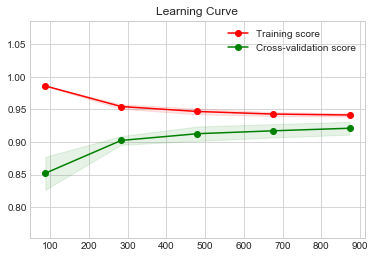

In [74]:
print('Optimal alpha:{}'.format(elnet_cv.alpha_))
print('Optimal l1_ratio: {}'.format(elnet_cv.l1_ratio_))
print('Number of iterations:{}'.format(elnet_cv.n_iter_))


elnet = ElasticNet(l1_ratio=elnet_cv.l1_ratio_, alpha = elnet_cv.alpha_, max_iter=elnet_cv.n_iter_, 
                   fit_intercept=True, normalize = False)
elnet.fit(train_X, train_y)
y_pred_val= elnet.predict(X= X_val)
print ("RMSLE Value : ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
train_sizes, train_scores, validation_scores = learning_curve(elnet, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
plot_learning_curve(train_sizes, train_scores, validation_scores)

In [75]:
y_pred_result = elnet.predict(X=test_X)
print(np.exp(y_pred_result[0:10])-1)

[112795.4026 154346.1226 176956.9688 196747.4394 197716.2864 169094.7598
 181315.8782 161873.82   191809.1392 118723.2922]


LassoCV(alphas=[0.0001, 0.0004, 0.0006, 0.00099], copy_X=True, cv=None,
    eps=0.001, fit_intercept=True, max_iter=50000, n_alphas=10000,
    n_jobs=1, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)
RMSLE Value :  0.11641046126228362


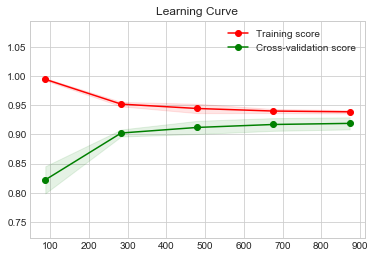

Optimal alpha:0.00099
Number of iterations:229


In [76]:
from sklearn.linear_model import LassoCV
lcv = LassoCV( n_alphas=10000, alphas= [0.0001,0.0004,0.0006,0.00099], fit_intercept=True, 
               normalize=False, precompute='auto', max_iter=50000)
lcv.fit(X_trainmodel, y_trainmodel)
print(lcv)
y_pred_val= lcv.predict(X= X_val)
print ("RMSLE Value : ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
train_sizes, train_scores, validation_scores = learning_curve(lcv, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
plot_learning_curve(train_sizes, train_scores, validation_scores)
print('Optimal alpha:{}'.format(lcv.alpha_))
print('Number of iterations:{}'.format(lcv.n_iter_))

In [77]:
y_pred_result = lcv.predict(X=test_X)
print(np.exp(y_pred_result[0:10])-1)

[111953.0533 135244.9178 178959.1075 196202.085  196512.0546 169156.7462
 182920.3346 160383.5646 194233.2874 118930.8926]


RMSLE Value :  0.11641046126228362


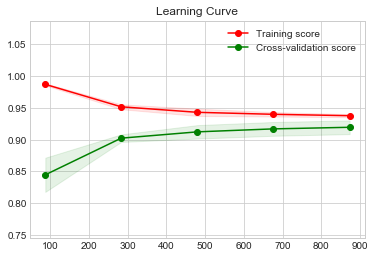

RMSLE Value : 0.11641046126228362


In [78]:
from sklearn.linear_model import Lasso
lasso =Lasso(alpha=lcv.alpha_ ,fit_intercept=True, normalize=False,
             precompute=False, max_iter=lcv.n_iter_,  selection='cyclic')
lasso.fit(X_trainmodel,y_trainmodel)
preds = lasso.predict(X_trainmodel)
print ("RMSLE Value : ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
train_sizes, train_scores, validation_scores = learning_curve(lasso, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
plot_learning_curve(train_sizes, train_scores, validation_scores)
y_pred_val= lasso.predict(X_val)
print ("RMSLE Value :",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))


In [79]:
y_pred_el_result = elnet.predict(X=test_X)
#y_pred_stregr_result = stregr.predict(test_X)
y_pred_lasso_result = elnet.predict(X=test_X)
#y_pred_result =(0.85*y_pred_el_result + 0.15*y_pred_stregr_result )
#y_pred_result =stregr.predict(test_X)
y_pred_result = np.exp(y_pred_el_result)-1
print(y_pred_result[0:10])

[112795.4026 154346.1226 176956.9688 196747.4394 197716.2864 169094.7598
 181315.8782 161873.82   191809.1392 118723.2922]


In [80]:
 
print(y_pred_result[0:10])
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="output/submission_housing_elastic_rework"+timestamp+"_out.csv"
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": y_pred_result
    })
submission.to_csv(filename, index=False)

[112795.4026 154346.1226 176956.9688 196747.4394 197716.2864 169094.7598
 181315.8782 161873.82   191809.1392 118723.2922]


In [81]:
coef = pd.DataFrame({'Features':X_trainmodel.columns,'coefficient':elnet.coef_})
coef_not_zero = coef[coef['coefficient']!=0].sort_values(by=['coefficient'] ,ascending =False)
coef_not_zero

,Features,coefficient
96,GrLivArea,0.0906
0,1stFlrSF,0.0581
178,OverallQual,0.0534
1,2ndFlrSF,0.0496
139,MSZoning_Rank,0.0441
177,OverallCond,0.0434
210,TotalBsmtSF,0.0434
84,Functional=Typ,0.0400
85,GarageCars,0.0354
46,Exterior1st=BrkFace,0.0339


In [82]:
coef_not_zero.to_csv("Selected_Features.csv", index=False)

In [83]:
selected_Features = coef_not_zero['Features'].values.tolist()
X_trainmodel = X_trainmodel[selected_Features]
X_val = X_val[selected_Features]
test_X= test_X[selected_Features]

In [84]:
heatmap_data =X_trainmodel
corr_matrix =heatmap_data.corr('pearson')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 
correlation_threshold = 0.80
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold) and column not in ['SalePrice','LogSalePrice']]
to_drop    

['GarageCond', 'GarageYrBlt']

In [85]:
correlated_predictors ={}
record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
for column in to_drop:
    co_related_features = list(upper.index[upper[column].abs() > correlation_threshold])
    co_related_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(co_related_features))]  

    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': co_related_features,
                                             'corr_value': co_related_values})
    record_collinear = record_collinear.append(temp_df, ignore_index = True)
record_collinear.sort_values(by=['corr_value'],ascending=True)

,drop_feature,corr_feature,corr_value
1,GarageYrBlt,GarageQual,0.9462
2,GarageYrBlt,GarageCond,0.9510
0,GarageCond,GarageQual,0.9576
